In [1]:
#git clone --recurse-submodules -j8 https://github.com/chto/SuperResPM.git
#!cd SuperResPM
#!sh install.sh

In [2]:
from functools import partial
import numpyro.distributions as dist
#import jax.numpy.fft as fft
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import numpy as np
import numpyro
from numpyro.handlers import condition
from pathlib import Path
import diffrax
import os,sys
import pickle
from diffrax import LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve, ConstantStepSize
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.pm import growth_factor, growth_rate, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.painting import cic_paint, cic_paint_2d, cic_read, compensate_cic
from jaxpm.distributed import fft3d, ifft3d, normal_field
from collections import namedtuple
import diffrax
from SuperResPM.configure import Configuration
from jax import tree
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
from jaxpm.pm import linear_field, lpt
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
jax.config.update("jax_enable_x64", False)


def linear_field_pm(mesh_shape, box_size, pk, seed, sharding=None,field=None):
    """
    Generate initial conditions.
    """
    # Initialize a random field with one slice on each gpu
    #field = normal_field(mesh_shape, seed=seed, sharding=sharding)]

    field = fft3d(field)
    kvec = fftk(field)
    kmesh = sum((kk / box_size[i] * mesh_shape[i])**2
                for i, kk in enumerate(kvec))**0.5
    pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
        box_size[0] * box_size[1] * box_size[2])

    field = field * (pkmesh)**0.5
    field = ifft3d(field)
    return field






def PM_numpyro_forward_model(
    linear_field,
    dens_model,
    cubegrid_size,
    cube_size,
):

    # Sample 2 cosmological parameters
    Omega_c = numpyro.sample("Omega_c", dist.Normal(0.26, 0.2))
    sigma8 = numpyro.sample("sigma8", dist.Normal(0.83, 1.0))

    # Set cosmology
    model_cosmo = jc.Cosmology(
        Omega_c=Omega_c,
        sigma8=sigma8,
        Omega_b=0.0492,
        Omega_k=0.0,
        h=0.67,
        n_s=0.96,
        w0=-1.0,
        wa=0.0,
    )
    Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
    model_cosmo._workspace =Workspace(None, None)
    ain=np.atleast_1d(1)
    _,model_cosmo = growth_rate(model_cosmo, ain)
    _,model_cosmo =  growth_rate_second(model_cosmo,ain)
    _,model_cosmo= growth_factor(model_cosmo, ain)
    _, model_cosmo= jc.background.radial_comoving_distance(model_cosmo, ain)

    # Generate linear field
    def pk_fn(x):
        # Create a small function to generate the matter power spectrum
        k = jnp.logspace(-4, 1, 128)
        pk = jc.power.linear_matter_power(model_cosmo, k)
        return jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    mesh_shape = [cubegrid_size, cubegrid_size, cubegrid_size]
    field = numpyro.sample(
        "initial_conditions", dist.Normal(jnp.zeros(mesh_shape), jnp.ones(mesh_shape))
    )
    lin_field = linear_field_pm(
        [cubegrid_size, cubegrid_size, cubegrid_size],
        [cube_size, cube_size, cube_size],
        pk_fn, jax.random.PRNGKey(0), field=field
    )

    # Evolve the density field
    dens = dens_model(model_cosmo, lin_field)

    # Sample noise
    ss = [cubegrid_size, cubegrid_size, cubegrid_size]
    obs = numpyro.sample("obs_dens",dist.Normal(dens, jnp.ones(ss)))

    numpyro.deterministic("dens",dens)

    return obs

def full_field_model_pm(
    cube_size,
    cubegrid_size,
    a_init,
    a_center,
    a_final, 
    dt
):
    @jax.jit
    def forward_model(cosmo, lin_field):
        # Create particles
        particles = jnp.stack(
            jnp.meshgrid(
                *[jnp.arange(s) for s in [cubegrid_size, cubegrid_size, cubegrid_size]]
            ),
            axis=-1,
        ).reshape([-1, 3])
        mesh_shape = [cubegrid_size, cubegrid_size, cubegrid_size]
        conf = Configuration(mesh_shape=mesh_shape, 
                     snapshots= a_center[::-1],
                     BoxSize=cube_size, 
                     initial_t0=a_init,
                     final_time =a_final,
                     density_plane_npix = 10,
                     dt0=dt)


        def paint_density(t, y, args):
            # Load positions and apply boundary conditions
            pos = y[0]
            #print(y.shape)
            x = pos[..., 1]
            y = pos[..., 2]
            z = pos[..., 0]

            # Paint all the particles that fall into slice
            ss=args[3].mesh_shape
            density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])

            return density
        
    

        eps, p, f = lpt(cosmo, lin_field, particles, a=conf.initial_t0)
        
        term = tree.map(
            FPMODE,
            symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
        )
        initforce = pm_forces(
            particles + eps,
            mesh_shape=mesh_shape,
            paint_absolute_pos=True,
        )* 1.5* cosmo.Omega_m  
        solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
        saveat = SaveAt(ts=a_center[::-1], fn=paint_density)
        
        stepsize_controller = ConstantStepSize()
        solution = diffeqsolve(
            term,
            solver,
            t0=conf.initial_t0,
            t1=conf.final_time,
            dt0=conf.dt0,
            y0=jnp.stack([particles + eps, p, initforce], axis=0),
            args=[cosmo, None, conf.initial_t0, conf, 0, 0],
            saveat=saveat,
            adjoint=diffrax.ReversibleAdjoint(),
            max_steps=32,
            stepsize_controller=stepsize_controller,
        )        
        return solution.ys[-1,:,:,:] # Just returning the last snapshot

    return forward_model


In [4]:
#####################################################################################################################

if __name__ == "__main__":
    key_number = 1

    # Set output directory
    dir_out = "./"
    Path(dir_out).mkdir(parents=True, exist_ok=True)

    # Sim configuration
    cube_size = 128  # Mpc/h
    cubegrid_size = 32  # npix
    a_init = 0.05 #t0
    a_final = 1 #t1
    dt = 0.03 #dt

    # Initialize the density model
    dens_model = full_field_model_pm(
        cube_size=cube_size,
        cubegrid_size=cubegrid_size,
        a_init = a_init,
        a_center=np.linspace(a_init,1,41)[::-1], 
        a_final =a_final,
        dt = dt
    )

    # Partially fix the forward model
    model = partial(
        PM_numpyro_forward_model,
        linear_field=linear_field_pm,
        dens_model=dens_model,
        cubegrid_size=cubegrid_size,
        cube_size=cube_size,
    )

    # Set keys
    keys = jax.random.PRNGKey(3)
    subkey = jax.random.split(keys, 200)
    key_data = subkey[key_number]
    key_run = subkey[key_number + 100]

    # Create a random realization of a map with fixed cosmology
    gen_model = condition(model, {"sigma8": 0.83, "Omega_c": 0.26})
    model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(gen_model, key_data))
    model_trace = model_tracer.get_trace()

    with open(dir_out+'model_trace.pkl', 'wb') as handle:
        pickle.dump(model_trace, handle, protocol=pickle.HIGHEST_PROTOCOL)


    # Set the starting point of the sampling (truth here)
    init_values = {
        "initial_conditions": model_trace["initial_conditions"]["value"],
        "sigma8": 0.83,
        "Omegac": 0.26,
    }

    # Condition the model (i.e. set target map)
    observed_model = condition(
        model,
        {'obs_dens': model_trace["obs_dens"]["value"]}
    )

    # Setup NUTS kernel
    nuts_kernel = numpyro.infer.NUTS(
        model=observed_model,
        init_strategy=numpyro.infer.init_to_value(values=init_values),
        max_tree_depth=8,
        step_size=0.01,
        dense_mass=False, 
        adapt_mass_matrix=True,
        adapt_step_size=True,
        find_heuristic_step_size=True
    )

    # Set up MCMC
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=100,
        num_samples=50,
        thinning=1,
        num_chains=1,
        chain_method="vectorized",
        progress_bar=True,
    )

    # Start sampling
    mcmc.run(key_run)
    res = mcmc.get_samples()

    with open(dir_out+'sample.pkl', 'wb') as handle:
        pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)


/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [1:12:17<00:00, 28.92s/it, 255 steps of size 6.75e-03. acc. prob=0.81]


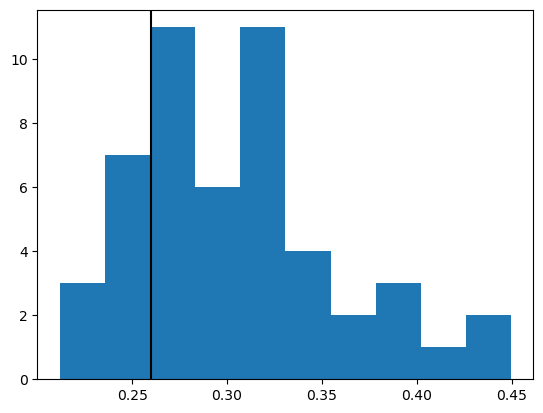

In [8]:
plt.hist(res['Omega_c'])
plt.axvline(0.26, c="k")

In [ ]:
if __name__ == "__main__":
    key_number = 1
    # Set output directory
    dir_out = "./"
    Path(dir_out).mkdir(parents=True, exist_ok=True)

    # Sim configuration
    cube_size = 128  # Mpc/h
    cubegrid_size = 100  # npix
    a_init = 0.05
    a_final = 1
    dt = 0.03
    # Initialize the density model
    dens_model = full_field_model_pm(
        cube_size=cube_size,
        cubegrid_size=cubegrid_size,
        a_init = a_init,
        a_center=np.linspace(a_init,1,41)[::-1], 
        a_final =a_final,
        dt = dt
    )

    # Partially fix the forward model
    model = partial(
        PM_numpyro_forward_model,
        linear_field=linear_field_pm,
        dens_model=dens_model,
        cubegrid_size=cubegrid_size,
        cube_size=cube_size,
    )

    # Set keys
    keys = jax.random.PRNGKey(3)
    subkey = jax.random.split(keys, 200)
    key_data = subkey[key_number]
    key_run = subkey[key_number + 100]

    # Create a random realization of a map with fixed cosmology
    gen_model = condition(model, {"sigma8": 0.83, "Omega_c": 0.26})
    model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(gen_model, key_data))
    model_trace = model_tracer.get_trace()
    #jax.debug.breakpoint()

    with open(dir_out+'model_trace.pkl', 'wb') as handle:
        pickle.dump(model_trace, handle, protocol=pickle.HIGHEST_PROTOCOL)


    # Set the starting point of the sampling (truth here)
    init_values = {
        "initial_conditions": model_trace["initial_conditions"]["value"],
        "sigma8": 0.83,
        "Omegac": 0.26,
    }

    # Condition the model (i.e. set target map)
    observed_model = condition(
        model,
        {'obs_dens': model_trace["obs_dens"]["value"]}
    )

    # Setup NUTS kernel
    nuts_kernel = numpyro.infer.NUTS(
        model=observed_model,
        init_strategy=numpyro.infer.init_to_value(values=init_values),
        max_tree_depth=5,
        step_size=0.01,
    )

    # Set up MCMC
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=1,
        num_samples=1,
        thinning=1,
        num_chains=1,
        chain_method="vectorized",
        progress_bar=True,
    )
    with jax.profiler.trace("tensorborard/"):
        # Start sampling
        mcmc.run(key_run)
        res2 = mcmc.get_samples()
    #with open(dir_out+'sample.pkl', 'wb') as handle:
    #    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)


2025-04-22 14:53:24.445141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745351604.470459 2940923 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745351604.478096 2940923 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745351604.760260 2940923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745351604.760301 2940923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745351604.760304 2940923 computation_placer.cc:177] computation placer alr